<a href="https://colab.research.google.com/github/Daisuke0209/EM_algorithm/blob/master/19302_bernouli_EMalgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリのインポート

In [0]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_mldata
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from scipy.special import logsumexp

## MNIST手書き文字のロード
Google ColabにはMNIST手書き文字データが標準でフォルダにある

In [60]:
df = pd.read_csv('/content/sample_data/mnist_train_small.csv')
df.columns = ['num']+[i+1 for i in range(784)]
df.head()

,num,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 数字=2,3,4のみ抽出

In [0]:
df = df[(df['num']==2) | (df['num']==3) | (df['num']==4)]
df = df[0:599]

### 試し表示

下の文字は2です


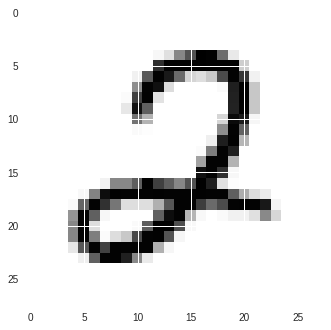

In [62]:
a = df[0:1].values
b = a[0,1:785]
b = b.reshape(28,28)
plt.imshow(b)
print('下の文字は%.dです'%a[0,0])

これは'2'だそうです(;´･ω･)

## 画像の２値化

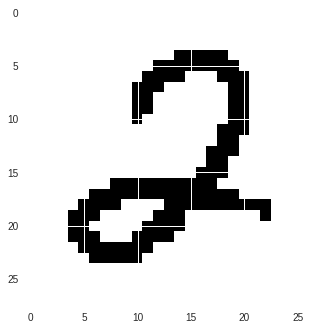

In [63]:
features = [col for col in df.columns if col not in ['num']]
target = df['num'].values
X = df[features].values
X = X/255

#画像の２値化
X = (X>0.5)*1

a = X[0]
a = a.reshape(28,28)

#画像表示
plt.imshow(a)

２値化で結構クッキリ見えました！

## 混合ベルヌーイ分布EMアルゴリズムの実装
混合ベルヌーイ分布アルゴリズムを実装する。

ここでは、
K = 3：混合分布における分布数
pi：混合係数
mu：各ベルヌーイ分布の平均
D：画像の次元数
N：学習画像の枚数
となる。

EMアルゴリズムの大まかな流れは、
1. 負担率の計算（Eステップ）
2. パラメータ更新（Ｍステップ）
となる。通常はパラメータ収束まで繰り返すが、
今回は簡単のため１０回繰り返し計算


### パラメータの初期化
混合係数の初期値は均等配分

muは、(0.25,0.75)の一様分布に従って振る

In [0]:
#混合分布における分布数
K=3
#混合係数初期化
pi = [1/K for i in range(K)]
#平均初期化
mu = []
for k in range(K):
  cash = []
  for i in range(784):
    #(0.25,0.75)の一様分布
    cash.append(np.random.uniform(0.25,0.75))
  #正規化
  cash = cash/np.sum(cash)
  mu.append(cash)

### 負担率の計算（Eステップ）
Eステップには注意点が２点ある。

注意点１：
負担率計算時にベルヌーイ分布の確率密度関数から確率を計算するが、確率密度関数は総和ではなく総乗計算になるため、帰り値がものすごく小さい値になってしまう（てか、０になるケースがある）。この場合、負担率が正しく計算されない（実際にやった）。
そこで、負担率の計算においては、logの世界で一旦計算し、最後にexpを作用させて負担率を計算する。ただし、負担率の分母計算ではlogsumexp関数を使う必要がある（logが直接、総乗項に作用できないため）。logsumexpの簡単な説明は、要はxをベクトルとしたとき、
logsumexp(x) = log(sum(exp(x)))
となる。

注意点２：
注意点１に従って、確率密度関数の対数を計算する際、μ=0,1になってしまうと対数確率密度関数が発散してしまう。そこで、μ=0,1の場合は0を返すことにした


In [0]:
D = 784
N = len(X)

#k番目のベルヌーイ分布に対する確率密度関数
#使っちゃだめ
def calc_p(mu,X,k,n,D):
  p = 1
  for i in range(D):
    p = p*(mu[k][i]**X[n][i])*((1-mu[k][i])**(1-X[n][i]))  
  return p
#k番目のベルヌーイ分布に対する対数確率密度関数
def calc_log_p(mu,X,k,n,D):
  p = 0
  for i in range(D):
    if mu[k][i]!=0 and mu[k][i]!=1:
      p = p+X[n][i]*np.log(mu[k][i])+(1-X[n][i])*np.log(1-mu[k][i])  
  return p
# 負担率の計算
#使っちゃだめ
def calc_gamma(mu, X, k, n, pi, K, D):
  sum = 0
  for j in range(K):
    sum = sum + pi[j]*calc_p(mu, X, j, n, D)
  if sum == 0:
    return 0
  else:
    return pi[k]*calc_p(mu, X, k, n, D)/sum
#負担率の計算（log-expをかましてる）
def calc_gamma_log(mu, X, k, n, pi, K, D):
  a = []
  for j in range(K):
    a.append(np.log(pi[j])+calc_log_p(mu,X,j,n,D))
  logsum = logsumexp(a)
  b = np.log(pi[k])+calc_log_p(mu,X,k,n,D)
  return np.exp(b-logsum) 

### パラメータ（平均、混合係数）更新（Ｍステップ）

In [0]:
def calc_param(N,gamma,k, X, D):
  #Nkの計算
  Nk = 0
  for n in range(N):
    Nk = Nk + gamma[k][n] 
  x = [0 for i in range(D)]
  for n in range(N):
    x = x + gamma[k][n]*X[n] 
  return Nk,x/Nk

### EMアルゴリズムの実行

In [0]:
imgs = []
#学習の実行
for i in range(10):
  imgs.append(mu)
  #Eステップ（負担率の計算）
  gamma = []
  for k in range(K):
    cash = []
    for n in range(N):
      a = calc_gamma_log(mu, X, k, n, pi, K, D)
      cash.append(a)
      if n%100 == 0:
        print('k=%.d,n=%.dは終了'%(k+1,n))    
    gamma.append(cash)
  #Mステップ（パラメータの更新）
  mu = []
  pi = []
  for k in range(K):
    xk = []
    Nk, xk = calc_param(N,gamma,k,X,D)
    pi.append(Nk/N)
    mu.append(xk)    

### 平均画像の表示

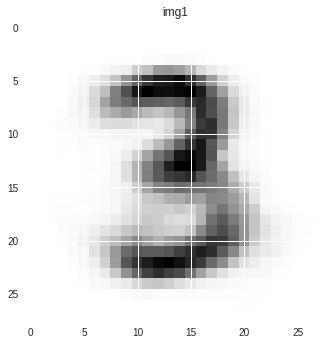

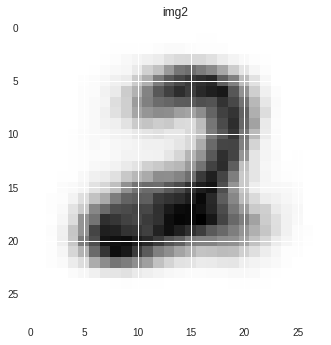

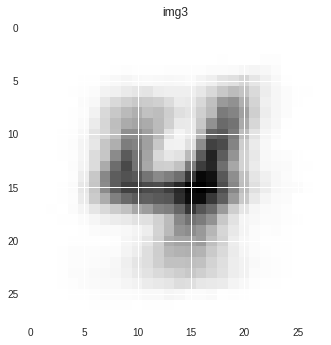

In [90]:
img1 = np.array(mu[0])
img1 = img1.reshape(28,28)
img2 = np.array(mu[1])
img2 = img2.reshape(28,28)
img3 = np.array(mu[2])
img3 = img3.reshape(28,28)
## 1枚目
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.set_title('img1')
img1 = ax.imshow(img1)

## 2枚目
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_title('img2')
img2 = ax.imshow(img2)

## 3枚目
fig3 = plt.figure()
ax = fig3.add_subplot(111)
ax.set_title('img3')
img3 = ax.imshow(img3)

## 表示
plt.show()

上から順に3,2,4がぼんやりと見えている
ぼんやりし過ぎ？？なんか間違えている？？